Крок 1 - Працюємл з данними, зведемо їх до одного формату, створимо спектограми

In [34]:
#Імпортуєм бібліотеки
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [35]:
#Завантажуємо датасети
DATA_DIR = {
    "motorcycle": "D:\Task For Practise Yura Stepovenko\Dataset\Motos",
    "background": "D:\Task For Practise Yura Stepovenko\Dataset\Ambient"
}

<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Admin\AppData\Local\Temp\ipykernel_9036\12434943.py:3: SyntaxWarning: invalid escape sequence '\T'
  "motorcycle": "D:\Task For Practise Yura Stepovenko\Dataset\Motos",
C:\Users\Admin\AppData\Local\Temp\ipykernel_9036\12434943.py:4: SyntaxWarning: invalid escape sequence '\T'
  "background": "D:\Task For Practise Yura Stepovenko\Dataset\Ambient"


In [36]:
#Параметри для обробки нашого аудіо
SAMPLE_RATE = 22050   # Цільова частота дискретизації
DURATION = 5          # Секунд
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [37]:
#Створюємо масив для
X = [] #Спектрограм
y = [] #Міток

In [38]:
#Коригуємо довжину звуків(потрібно лише для звуків ембіенту, бо звуки мотоцикла - усі по 5 секунд)
def fix_audio_length(audio, target_length):
    """Обрізає або доповнює аудіо до точно target_length семплів"""
    if len(audio) < target_length:
        # Доповнюємо тишею (нулями)
        pad_width = target_length - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')
    elif len(audio) > target_length:
        # Обрізаємо зайве
        audio = audio[:target_length]
    return audio

def process_audio_file(filepath, label):
    try:
        audio, sr = librosa.load(filepath, sr=SAMPLE_RATE, mono=True)
        
        if sr != SAMPLE_RATE:
            print(f"[i] Перетворено SR {sr} → {SAMPLE_RATE}")

        if len(audio) != SAMPLES_PER_TRACK:
            print(f"[~] {os.path.basename(filepath)}: довжина = {len(audio)/sr:.2f} сек , фіксуємо")
            audio = fix_audio_length(audio, SAMPLES_PER_TRACK)
        
        # Створення mel-спектрограми
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db, label

    except Exception as e:
        print(f"[X] Помилка при обробці {filepath}: {e}")
        return None, None


In [39]:
# Обхід всіх файлів
for label_str, path in DATA_DIR.items():
    label = 1 if label_str == "motorcycle" else 0
    for filename in os.listdir(path):
        if not filename.endswith(".wav"):
            print(f"[!] Пропущено не WAV-файл: {filename}")
            continue
        filepath = os.path.join(path, filename)
        mel, lbl = process_audio_file(filepath, label)
        if mel is not None:
            X.append(mel)
            y.append(lbl)


[~] chainsaw_1_7.wav: довжина = 4.25 сек , фіксуємо
[~] chainsaw_5_region_000.wav: довжина = 6.24 сек , фіксуємо
[~] chainsaw_5_region_001.wav: довжина = 5.97 сек , фіксуємо
[~] chainsaw_5_region_002.wav: довжина = 5.54 сек , фіксуємо
[~] chainsaw_6_region_003.wav: довжина = 4.34 сек , фіксуємо
[~] chainsaw_7_region_004.wav: довжина = 4.34 сек , фіксуємо
[~] chainsaw_7_region_005.wav: довжина = 4.32 сек , фіксуємо
[~] chainsaw_9_region_006.wav: довжина = 5.17 сек , фіксуємо
[~] chainsaw_9_region_007.wav: довжина = 4.97 сек , фіксуємо
[~] chainsaw_9_region_008.wav: довжина = 5.12 сек , фіксуємо
[~] chainsaw_9_region_009.wav: довжина = 5.32 сек , фіксуємо
[~] chainsaw_9_region_010.wav: довжина = 5.44 сек , фіксуємо
[~] chainsaw_9_region_011.wav: довжина = 4.83 сек , фіксуємо
[~] chainsaw_9_region_012.wav: довжина = 5.33 сек , фіксуємо
[~] chainsaw_9_region_013.wav: довжина = 4.75 сек , фіксуємо
[~] chainsaw_b_region_014.wav: довжина = 4.90 сек , фіксуємо
[~] chainsaw_b_region_015.wav: до

In [40]:
# Перетворення в масиви
X = np.array(X)
y = np.array(y)

np.save("mel_spectrograms_X.npy", X)
np.save("labels_y.npy", y)

print(f"Оброблено {len(X)} аудіофайлів.")
print(f"Форма спектрограми: {X[0].shape}")
print(f"Мітки (y): {np.unique(y, return_counts=True)}")

Оброблено 1036 аудіофайлів.
Форма спектрограми: (128, 216)
Мітки (y): (array([0, 1]), array([518, 518]))


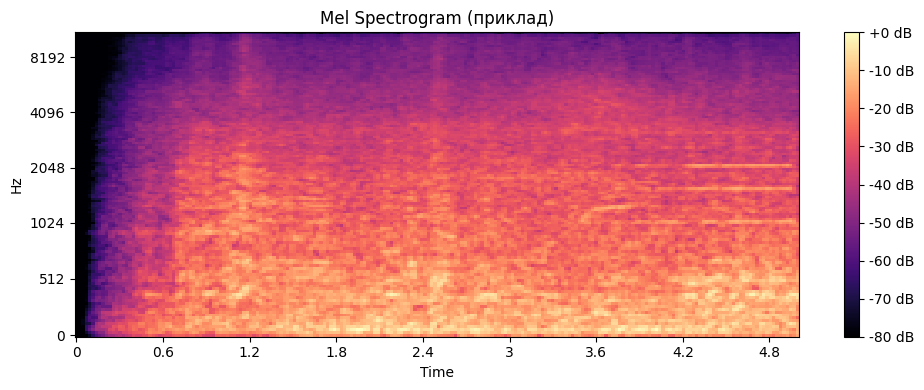

In [41]:
#Приклад спектрограми
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[0], sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram (приклад)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


Крок 2 - Завантажимо данні

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [43]:
#Завантаження спектрограм і міток
X = np.load("mel_spectrograms_X.npy")  # shape: (N, 128, time)
y = np.load("labels_y.npy")

In [44]:
#Розширення розмірності (1 канал для CNN)
X = X[:, np.newaxis, :, :]  # (N, 1, 128, time)

In [45]:
#Перетворення в тензори
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [46]:
#Користувацький Dataset
class SoundDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
dataset = SoundDataset(X_tensor, y_tensor)

In [47]:
# Розділення: 80% train, 20% val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Крок 3 - Напишемо параметри нейронної мережі

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)

        # Виставляємо розмір вхідного шару для fully connected
        self._to_linear = None
        self._get_conv_output_shape()

        self.fc1 = nn.Linear(self._to_linear, 64)
        self.fc2 = nn.Linear(64, 2)

    def _get_conv_output_shape(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 128, 216)  # такий самий розмір, як у спектрограми
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # розплющення для fully connected шару
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Крок 4 - тренування моделі

In [49]:
#Використовуємо GPU Для навчання моделі
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier().to(device)

In [50]:
#Налаштовуємо оптимізатор(найоптимальніший - адам)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:
#Кількість епох навчання (з цим параметром не грався, для тесту виставив 20 - запрацювало, можливо якщо виставити меньше модель не втратить ефективності,
# але я не перевіряв.)
EPOCHS = 20

In [52]:
#Цикл для тренування 20 епох нейронної мережі.
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    train_acc = correct / train_size

    # Валідація
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_size

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss:.4f} - Train acc: {train_acc:.3f} - Val acc: {val_acc:.3f}")


Epoch 1/20 - Loss: 112.3056 - Train acc: 0.758 - Val acc: 0.990
Epoch 2/20 - Loss: 1.0692 - Train acc: 0.990 - Val acc: 1.000
Epoch 3/20 - Loss: 0.4589 - Train acc: 0.995 - Val acc: 0.995
Epoch 4/20 - Loss: 0.1842 - Train acc: 0.999 - Val acc: 0.995
Epoch 5/20 - Loss: 0.0752 - Train acc: 1.000 - Val acc: 1.000
Epoch 6/20 - Loss: 0.0373 - Train acc: 1.000 - Val acc: 0.995
Epoch 7/20 - Loss: 0.0390 - Train acc: 1.000 - Val acc: 0.995
Epoch 8/20 - Loss: 0.0239 - Train acc: 1.000 - Val acc: 1.000
Epoch 9/20 - Loss: 0.0170 - Train acc: 1.000 - Val acc: 0.995
Epoch 10/20 - Loss: 0.0128 - Train acc: 1.000 - Val acc: 1.000
Epoch 11/20 - Loss: 0.0086 - Train acc: 1.000 - Val acc: 1.000
Epoch 12/20 - Loss: 0.0042 - Train acc: 1.000 - Val acc: 1.000
Epoch 13/20 - Loss: 0.0064 - Train acc: 1.000 - Val acc: 1.000
Epoch 14/20 - Loss: 0.0035 - Train acc: 1.000 - Val acc: 1.000
Epoch 15/20 - Loss: 0.0024 - Train acc: 1.000 - Val acc: 1.000
Epoch 16/20 - Loss: 0.0024 - Train acc: 1.000 - Val acc: 1.000

In [53]:
#Зберігаємо модель
torch.save(model.state_dict(), "motorcycle_sound_cnn.pth")

Крок 5 - пожинаємо плоди нашої праці - перевіряємо модель.

In [64]:
import torch
import torch.nn.functional as F
import librosa
import numpy as np

#Гіперпараметри
SAMPLE_RATE = 22050
DURATION = 5
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

#Завантаження аудіо та обробка
def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

    # Фіксуємо довжину
    if len(audio) < SAMPLES_PER_TRACK:
        pad = SAMPLES_PER_TRACK - len(audio)
        audio = np.pad(audio, (0, pad), mode='constant')
    elif len(audio) > SAMPLES_PER_TRACK:
        audio = audio[:SAMPLES_PER_TRACK]

    # Mel-спектрограма
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Перетворення в тензор
    mel_tensor = torch.tensor(mel_spec_db, dtype=torch.float32)
    mel_tensor = mel_tensor.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, 128, time)
    return mel_tensor

# === Клас нейронної мережі (той самий, що під час навчання) ===
class CNNClassifier(torch.nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout = torch.nn.Dropout(0.3)

        # Динамічне визначення розміру перед fc1
        self._to_linear = None
        self._get_conv_output_shape()

        self.fc1 = torch.nn.Linear(self._to_linear, 64)
        self.fc2 = torch.nn.Linear(64, 2)

    def _get_conv_output_shape(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 128, 216)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# === Передбачення ===
def predict(file_path, model_path="motorcycle_detector.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNClassifier().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    input_tensor = preprocess_audio(file_path).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probs).item()
        confidence = probs[0][predicted_class].item()

    labels = ["фон", "мотоцикл"]
    print(f" Файл: {file_path}")
    print(f" Клас: {labels[predicted_class]} (ймовірність: {confidence:.2%})")



In [55]:
torch.save(model.state_dict(), "motorcycle_detector.pth")

In [65]:
predict("Test_sound.wav")

 Файл: Test_sound.wav
 Клас: фон (ймовірність: 100.00%)


In [66]:
predict("Test_Motorcycle.wav")

 Файл: Test_Motorcycle.wav
 Клас: мотоцикл (ймовірність: 99.00%)


<Figure size 600x600 with 0 Axes>

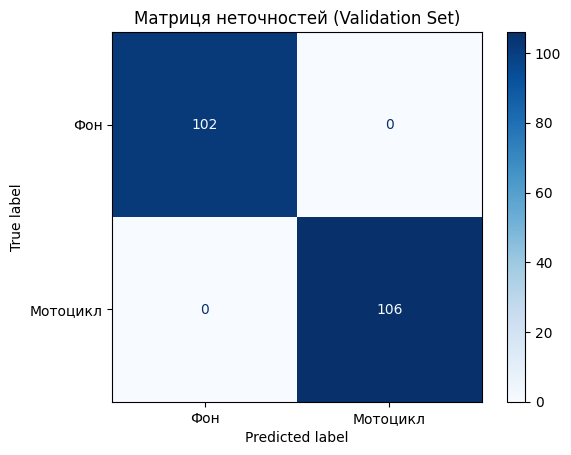

In [58]:
#Створимо матрицю неточностей
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Передбачення на validation set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

#Побудова матриці неточностей
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Фон", "Мотоцикл"])

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця неточностей (Validation Set)")
plt.grid(False)
plt.show()


In [59]:
from sklearn.metrics import classification_report

#Повний звіт з метриками
report = classification_report(all_labels, all_preds, target_names=["Фон", "Мотоцикл"])
print("Метрики класифікації на Validation Set:\n")
print(report)


Метрики класифікації на Validation Set:

              precision    recall  f1-score   support

         Фон       1.00      1.00      1.00       102
    Мотоцикл       1.00      1.00      1.00       106

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208

